In [53]:
import wandb

import os
import sys
sys.path.append('../environments')
import numpy as np
import matplotlib.pyplot as plt
import random

import gymnasium as gym
from gymnasium.spaces import Dict


import os
import sys
sys.path.append('../src/')
from neural_nets import DQN, exponential_schedule, linear_schedule
from buffer import ReplayBuffer
from scipy.spatial.distance import cdist

# import wandb

import torch
import torch.nn as nn
from torch.nn import functional as F

In [54]:
def get_distance_matrix(X,Y):
  """"""
  return cdist(X,Y,metric='euclidean')

def get_distance(point1,point2):
    """Compute Euclidean distance between two points."""
    return np.linalg.norm(point1 - point2)

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = False

# Setup experiment

In [ ]:
env_name = 'ToyEnv_v2'

OUTDIR = f'results/{env_name}/'
if not os.path.exists(OUTDIR):
    os.makedirs(OUTDIR)
    
train_size = 1
SEED = 10
seed_everything(SEED)

torch.set_default_dtype(torch.float32)

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Simulate train data

In [58]:
def get_closest_dist_ordering(coords, distance_matrix):
    """
    Given a list of coordinates, picks the field closest to the origin first, then 
    always picks the field closest unless it has already been visited
    """
    # matrix where each row corresponds to ordered indices of which is furthest
    ordered_mat_indices = np.argsort(distance_matrix, axis=1) # low to high

    # get index closest to origin
    last_ind = 0
    target_indices = [last_ind]
    row_index = last_ind
    for _ in range(len(coords) - 1):
        col_index = 0 # index of col of matrix

       # if this index has already been chosen, 
        current_ind = ordered_mat_indices[row_index][col_index]
        while current_ind in target_indices:
            col_index += 1
            current_ind = ordered_mat_indices[row_index][col_index]
        target_indices.append(current_ind)
        row_index = current_ind
    return target_indices

def reward_function(target_coords):
    coords = target_coords[:, :-1, :]
    last_coords = target_coords[:, 1:, :]
    
    separation = np.linalg.norm(coords - last_coords, axis=2)
    mean_sep, std_sep = np.mean(separation), np.std(separation)
    
    low_sep_lim = mean_sep - .5 * std_sep
    mid_sep_lim = mean_sep + .5 * std_sep
    max_sep_lim = mean_sep + 1.5 * std_sep
    max_reward_mask = separation < low_sep_lim
    mid_reward_mask = np.logical_and(separation < mid_sep_lim, separation >= low_sep_lim)
    low_reward_mask = np.logical_and(separation <= max_sep_lim, separation >= mid_sep_lim)
    reward_shape = (len(target_coords), len(target_coords[0]) - 1)
    rewards = np.zeros(shape=reward_shape, dtype=np.float32)
    rewards[low_reward_mask] = .1
    rewards[mid_reward_mask] = .5
    rewards[max_reward_mask] = 1
    return rewards, separation

def get_nvisits(target_field_ids, nfields):
    # start with 0 visits
    train_size = len(target_field_ids)
    nvisits_base = np.zeros(shape=(nfields), dtype=np.int32)
    full_nvisits = np.zeros(shape=(train_size, len(target_field_ids[0]) - 1, nfields), dtype=np.int32)

    # for each night and each field in night, add 1 count to field then copy new nvisits base into full_nvisits[night,obs]
    for i, night_obs in enumerate(target_field_ids):
        for j, field_id in enumerate(night_obs[1:]):
            nvisits_base[field_id] += 1
            full_nvisits[i, j] = nvisits_base.copy()
        # print(np.argwhere(nvisits_base))
    return full_nvisits

In [59]:
def generate_dataset(n_datasets=100):
    """
    Generates the following dataset
        (1) a random sample of points on a 20x20 integer grid for x number of nights with a static number of observations per night.
        (2) Each night the first observation is always the one that is closest to zenith, and always chooses the next point to be the one that is closest.
        (3) The set of quantities needed to perform training
    
    Returns
    -------
    
    """
    grid_max = 5
    ra_range = (-grid_max, grid_max)
    dec_range = (-grid_max, grid_max)
    # set number of unique fields
    n_unique = 10
    # n_unique = int(n_datasets//num_repeats*10)
    num_repeats = (n_datasets * 10 //n_unique )
    print(num_repeats, n_unique)
    # generate random coords
    ra_list = np.random.randint(ra_range[0], ra_range[1], size=(n_unique), dtype=np.int32)
    dec_list = np.random.randint(dec_range[0], dec_range[1], size=(n_unique), dtype=np.int32)

    unique_coords = np.stack([ra_list, dec_list], axis=1) # shape (num_ep, nra_points, ndec_points)

    # flattened_coords = coords.reshape(int(np.prod(coords.shape[:2])), 2)
    # unique_coords = np.unique(flattened_coords, axis=0)
    unique_field_ids = np.arange(len(unique_coords), dtype=np.int32)
    field_coord_mapping = {id: c for id, c in zip(unique_field_ids, unique_coords)}
    field_coord_mapping.update({-1: np.array([0,0])})

    # repeat coords for full dataset
    coords = np.repeat(unique_coords, num_repeats, axis=0)
    field_ids = np.repeat(unique_field_ids, num_repeats)
    
    # randomize order
    new_indices = list(range(len(coords)))
    random.shuffle(new_indices)
    coords = coords[new_indices]
    field_ids = field_ids[new_indices]
    coords = coords.reshape((n_datasets, 10, 2))
    field_ids = field_ids.reshape((n_datasets, 10))
     
    # include "-1" fields ie (0,0)
    zeros = np.zeros(shape=(n_datasets, 2), dtype=np.int32)
    coords = np.concatenate((zeros[:, np.newaxis, :], coords), axis=1)
    field_ids = np.concatenate( (np.full(n_datasets, fill_value=-1)[:, np.newaxis], field_ids), axis=1)

    distance_matrices = np.empty(shape=(n_datasets, 10+1, 10+1), dtype=np.float32)
    full_target_fields = []
    full_target_coords = []

    for i in range(n_datasets):
        distance_matrices[i] = get_distance_matrix(coords[i], coords[i])
        np.fill_diagonal(distance_matrices[i], np.inf)
        target_indices = get_closest_dist_ordering(coords[i], distance_matrices[i])
        full_target_fields.append(field_ids[i][target_indices])
        full_target_coords.append(coords[i][target_indices])

    full_target_fields = np.array(full_target_fields, dtype=np.int32)
    full_target_coords = np.array(full_target_coords, dtype=np.int32)
    nfields =  np.int32(len(np.unique(full_target_fields)) - 1)
    max_visits = np.int32(len(full_target_fields) // nfields * (len(full_target_fields[0]) - 1))
    full_nvisits = get_nvisits(full_target_fields, nfields)
    # full_stepnum = np.array([np.arange(0, 10, dtype=np.int32) for i in range(len(full_target_fields))], dtype=np.int32)
    
    # obs: stepnum, target_coords, target_field_ids, nvisits
    # full_obs = (full_target_fields[:, :-1]) #full_target_coords[:, :-1], full_stepnum[:, :-1], , full_nvisits[:, :-1])
    # full_next_obs = (full_target_fields[:, 1:]) #full_target_coords[:, 1:], full_stepnum[:, 1:], , full_nvisits[:, 1:])
    full_actions = full_target_fields[:, 1:]
    full_rewards, full_separations = reward_function(full_target_coords)
    full_dones = np.zeros_like(full_target_fields[:, 1:], dtype=bool)
    full_dones[:, -1] = True
    full_action_masks = full_nvisits != max_visits
    # full_action_mask = action_masks[:, :-1]
    # full_next_action_mask = action_masks[:, 1:]

    return full_target_fields, full_actions, full_rewards, full_dones, full_action_masks, full_target_coords, nfields, max_visits, full_separations, field_coord_mapping

In [64]:
full_target_fields, full_actions, full_rewards, full_dones, full_action_masks, full_target_coords, nfields, max_visits, full_separations, field_coord_mapping \
    = generate_dataset(train_size)

1 10


(array([1., 1., 1., 1., 3., 1., 0., 0., 1., 1.]),
 array([0.        , 0.70710678, 1.41421356, 2.12132034, 2.82842712,
        3.53553391, 4.24264069, 4.94974747, 5.65685425, 6.36396103,
        7.07106781]),
 <BarContainer object of 10 artists>)

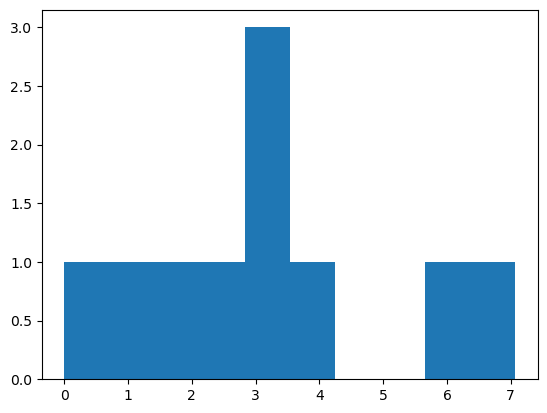

In [65]:
plt.hist(full_separations.flatten())

Text(0.5, 1.0, 'Separations')

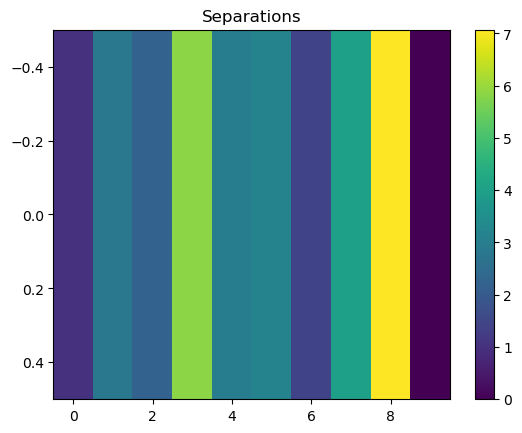

In [66]:
c = plt.imshow(full_separations, aspect='auto')
plt.colorbar(c)
plt.title('Separations')

(array([1., 1., 0., 0., 0., 5., 0., 0., 0., 3.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

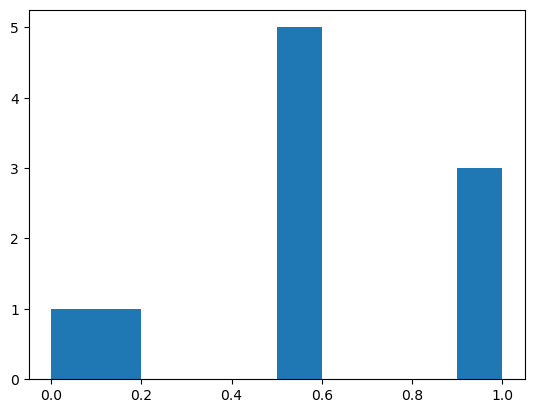

In [67]:
plt.hist(full_rewards.flatten())

10


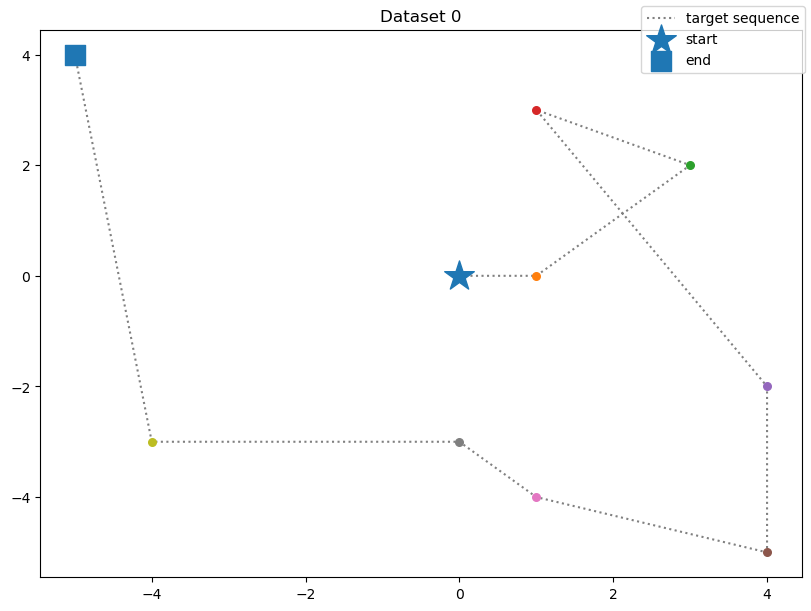

In [68]:
j = np.random.randint(train_size)

fig, ax = plt.subplots(figsize=(8, 6), layout='constrained')
ax.plot(full_target_coords[j][:, 0], full_target_coords[j][:, 1], linestyle='dotted', label='target sequence', zorder=1, color='grey')

for i, index in enumerate(full_target_fields[j]):
    if i == 0:
        marker = '*'
        s = 500
        label='start'
    elif i == len(full_target_fields[j])-1:
        print(i)
        marker = 's'
        s = 200
        label='end'
    else:
        marker = 'o'
        s = 30
        label=None
    ax.scatter(full_target_coords[j][i][0], full_target_coords[j][i][1], marker=marker, s=s, label=label)
# fig.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
fig.legend()
ax.set_title(f'Dataset {j}');

In [69]:
from collections.abc import Callable

class ToyOfflineData:
    def __init__(self, data_generator: Callable, train_size: int):
        self.data_generator = data_generator
        self.train_size = train_size
        self.obs, self.actions, self.rewards, self.dones, self.action_masks, self._full_target_coords, self._nfields, self._max_visits, self._full_separations, self._field_coord_mapping\
            = data_generator(train_size)
        self._obs_per_night = len(self.obs[0])
        self._obs_dim = 1 # just observing field
        self._action_dim = self._nfields
    def __len__(self):
        return len(self.obs)

    def sample(self, batch_size):
        night_indices = np.random.choice(self.train_size, batch_size, replace=True)
        step_num_indices = np.random.choice(self._obs_per_night - 1, batch_size)
        
        return (
            np.array(self.obs[night_indices, step_num_indices], dtype=np.float32), # needs to be float for network
            np.array(self.actions[night_indices, step_num_indices], dtype=np.int32),
            np.array(self.rewards[night_indices, step_num_indices], dtype=np.float32),
            np.array(self.obs[night_indices, step_num_indices+1], dtype=np.float32),
            np.array(self.dones[night_indices, step_num_indices], dtype=np.bool_),
            np.array(self.action_masks[night_indices, step_num_indices], dtype=bool),
        )

# Pytorch Agent and DQN implementation

In [70]:
from neural_nets import DQN

In [84]:
class Algorithm:
    def __init__(self):
        super().__init__()
        
    def train_step(self):
        raise NotImplementedError

    def select_action(self):
        raise NotImplementedError
    
class DDQN(Algorithm):
    def __init__(self, obs_dim, action_dim, hidden_dim, gamma, tau, device, lr, loss_fxn, use_dqn=False, **optimizer_kwargs):
        super().__init__()
        self.gamma = gamma
        self.tau = tau
        self.device = device

        self.policy_net = DQN(obs_dim, action_dim, hidden_dim).to(device)
        self.target_net = DQN(obs_dim, action_dim, hidden_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.use_dqn = use_dqn

        self.optimizer = torch.optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=False, **optimizer_kwargs)

        # #TODO
        self.scheduler=None
        # lr_scheduler_kwargs = {'T_max': 10_000, 'eta_min': 1e-6}
        # self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, **lr_scheduler_kwargs)
        self.loss_fxn = F.mse_loss if loss_fxn is None else loss_fxn

    def train_step(self, batch):
        obs, actions, rewards, next_obs, dones, action_masks = batch

        # convert to tensors
        obs = torch.tensor(np.array(obs), device=device, dtype=torch.float32)
        actions = torch.tensor(actions, device=device, dtype=torch.long).unsqueeze(1) # needs to be long for .gather()
        rewards = torch.tensor(rewards, device=device, dtype=torch.float32)
        next_obs = torch.tensor(np.array(next_obs), device=device, dtype=torch.float32)
        dones = torch.tensor(dones, device=device, dtype=torch.float32)
        action_masks = torch.tensor(np.array(action_masks), device=device, dtype=torch.bool)
        
        # need to input (batch_size, obs_dim) into net - if obs_dim is 1, we get 1d tensor. Need to reshape
        if obs.dim() == 1:
            obs = obs.unsqueeze(1)
            next_obs = next_obs.unsqueeze(1)
    
        # get policy q vals for current state
        all_q_vals = self.policy_net(obs)
        current_q = all_q_vals.gather(1, actions).squeeze()

        # ddqn
        with torch.no_grad():
            if self.use_dqn:
                next_q = self.target_net(next_obs)

                # mask invalid actions
                mask_tensor = torch.tensor(action_masks, device=device, dtype=torch.bool)
                next_q[~mask_tensor] = -1e9# float('-inf')
                # wandb_run.log({'masked next q': next_q},step=t_i)

                max_next_q = next_q.max(dim=1)[0]
                # print('(7) max_masked_next_q', max_next_q)

                td_target = rewards + self.gamma * max_next_q * (1 - dones) # , dtype=torch.float32, device=device
            else:
                # get policy best actions (need to mask invalid actions)
                next_q_pol = self.policy_net(next_obs)
                # mask_tensor = torch.tensor(action_masks, device=device, dtype=torch.bool)
                next_q_pol[~action_masks] = -1e9

                next_actions_pol = next_q_pol.argmax(1).type(torch.long)
                next_q_targ = self.target_net(next_obs).gather(1, next_actions_pol.unsqueeze(1)).squeeze(1)

                # dqn style 
                # max_next_q = next_q.max(dim=1)[0]

                td_target = rewards + self.gamma * (1 - dones) * next_q_targ

        loss = self.loss_fxn(current_q, td_target)
        
        # optimize w/ backprop
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), max_norm=1.)
        self.optimizer.step()
        if self.scheduler:
            self.scheduler.step()

                    
        self._soft_update()

        # soft update done in agent
        return loss.item(), current_q.mean().item()

    def _soft_update(self):
        # update target network
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def select_action(self, obs, action_mask, epsilon=None):
        # if random sample less than epsilon, take random action
        if epsilon is not None:
            if np.random.random() < epsilon:
                valid_actions = np.where(action_mask)[0]
                action = np.random.choice(valid_actions)
                return int(action)

        # greedy selection from policy
        obs = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.policy_net(obs).squeeze(0)
            # mask invalid actions
            mask = torch.tensor(action_mask, device=self.device, dtype=torch.bool)
            q_values[~mask] = float('-inf')
            action = torch.argmax(q_values).item()
        return int(action)
    
    def save(self, filepath):
        torch.save({'policy_net': self.policy_net.state_dict()}, filepath)
    
    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=self.device)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
    


In [85]:
class Agent:
    def __init__(
            self,
            algorithm,
            name,
            env=None,
            ):
        self.algorithm = algorithm
        self.device = algorithm.device
        self.name = name
        self.loss_history = []
        self.q_history = []

    def fit(self, dataset, num_epochs, batch_size, target_freq, outdir, version_num=0):

        for i_epoch in range(num_epochs):
            print('\t epoch: ' + f'{i_epoch}')
            batch = dataset.sample(batch_size)
            
            loss, q_val = self.algorithm.train_step(batch)
            self.loss_history.append(loss)
            self.q_history.append(q_val)

        save_filepath = outdir + self.name + f'-v{version_num}.pt'
        self.save(save_filepath)


    def evaluate(self, env, num_episodes, deterministic):
        raise NotImplementedError

    def act(self, state, epsilon):
        return self.algorithm.select_action(state, epsilon)
    
    def save(self, filepath):
        self.algorithm.save(filepath)
    
    def load(self, filepath):
        self.algorithm.load(filepath)
    
    def get_schedule(self, num_observations):
        """
        Rolls out policy.

        Returns
        ------
        buffer: ReplayBuffer
            Memory of this roll-out
        log: Dict
            Contains quantities that might be useful for diagnostics
        """
        log = {
            'rewards': [],
            'obs': [],
            'terminated': [],
            'action_mask': []
            }
        
        self.reset()
        buffer = ReplayBuffer(num_observations, device=self.device)
        for _ in range(num_observations):

            if terminated:
                break
        return buffer, log
        

            

In [86]:
dataset = ToyOfflineData(generate_dataset, train_size)

1 10


In [87]:
alg_config = {
    'obs_dim': dataset._obs_dim,
    'action_dim': dataset._action_dim,
    'hidden_dim': 128,
    'gamma': .99,
    'tau': .005,
    'device': device,
    'lr': 1e-5,
    'loss_fxn': F.mse_loss,
    'use_dqn': False
}

alg = DDQN(**alg_config)

In [88]:
agent_config = {
    'algorithm': alg,
    'name': 'ddqnAgent'
    }

In [89]:
agent = Agent(**agent_config)

In [90]:
agent.fit(
    dataset,
    num_epochs=10000,
    batch_size=16, 
    target_freq=4,
    outdir=OUTDIR
    )

	 epoch: 0
	 epoch: 1
	 epoch: 2
	 epoch: 3
	 epoch: 4
	 epoch: 5
	 epoch: 6
	 epoch: 7
	 epoch: 8
	 epoch: 9
	 epoch: 10
	 epoch: 11
	 epoch: 12
	 epoch: 13
	 epoch: 14
	 epoch: 15
	 epoch: 16
	 epoch: 17
	 epoch: 18
	 epoch: 19
	 epoch: 20
	 epoch: 21
	 epoch: 22
	 epoch: 23
	 epoch: 24
	 epoch: 25
	 epoch: 26
	 epoch: 27
	 epoch: 28
	 epoch: 29
	 epoch: 30
	 epoch: 31
	 epoch: 32
	 epoch: 33
	 epoch: 34
	 epoch: 35
	 epoch: 36
	 epoch: 37
	 epoch: 38
	 epoch: 39
	 epoch: 40
	 epoch: 41
	 epoch: 42
	 epoch: 43
	 epoch: 44
	 epoch: 45
	 epoch: 46
	 epoch: 47
	 epoch: 48
	 epoch: 49
	 epoch: 50
	 epoch: 51
	 epoch: 52
	 epoch: 53
	 epoch: 54
	 epoch: 55
	 epoch: 56
	 epoch: 57
	 epoch: 58
	 epoch: 59
	 epoch: 60
	 epoch: 61
	 epoch: 62
	 epoch: 63
	 epoch: 64
	 epoch: 65
	 epoch: 66
	 epoch: 67
	 epoch: 68
	 epoch: 69
	 epoch: 70
	 epoch: 71
	 epoch: 72
	 epoch: 73
	 epoch: 74
	 epoch: 75
	 epoch: 76
	 epoch: 77
	 epoch: 78
	 epoch: 79
	 epoch: 80
	 epoch: 81
	 epoch: 82
	 epoch: 83
	 

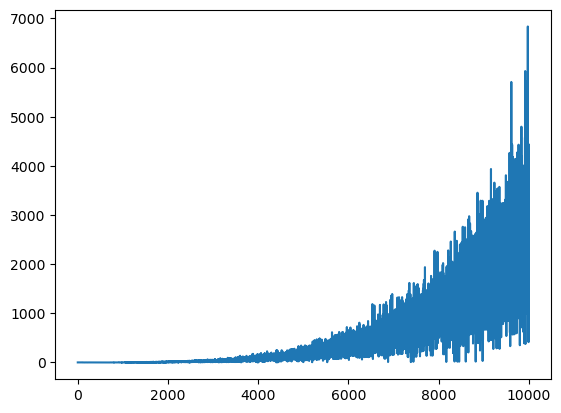

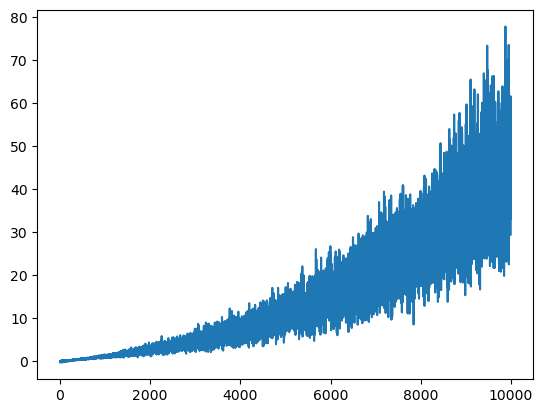

In [91]:
plt.plot(agent.loss_history)
plt.show();
plt.plot(agent.q_history)

# Evaluate

In [ ]:
def evaluate(self, env, num_episodes, render=False):
    episode_rewards = []
    
    for episode in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0
        terminated = False
        truncated = False
        
        while not (terminated or truncated):
            action_mask = info.get('action_mask', None)
            action = self.algorithm.select_action(obs, action_mask, epsilon=None)  # greedy
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            
            if render:
                env.render()
        
        episode_rewards.append(episode_reward)
    
    return {
        'mean_reward': np.mean(episode_rewards),
        'std_reward': np.std(episode_rewards),
        'min_reward': np.min(episode_rewards),
        'max_reward': np.max(episode_rewards)
    }

In [25]:
vars(dataset).keys()

dict_keys(['data_generator', 'train_size', 'obs', 'actions', 'rewards', 'dones', 'action_masks', '_full_target_coords', '_nfields', '_max_visits', '_full_separations', '_field_coord_mapping', '_obs_per_night', '_obs_dim', '_action_dim'])

In [50]:
dataset.actions

array([[2, 9, 7, 1, 1, 0, 0, 8, 8, 6],
       [3, 4, 4, 4, 0, 1, 1, 8, 7, 5],
       [2, 2, 3, 3, 3, 4, 5, 9, 7, 8],
       [2, 2, 6, 6, 6, 5, 9, 9, 1, 0],
       [3, 6, 5, 5, 9, 7, 7, 0, 8, 4]], dtype=int32)

In [ ]:
class ToyEnv_v2(gym.Env):
    def __init__(self, dataset):
        super().__init__()
        # instantiate static attributes
        self.coords_dict = dataset._field_coord_mapping # field_id: (x,y)
        self.nfields = dataset._nfields
        self.max_visits = 1
        self.zenith = dataset._field_coord_mapping[-1]
        self._n_obs_per_night = dataset._obs_per_night

        # Initialize variable attributes - will be set in reset()
        self._init_to_nonstate()
       
        # Define observation space - (step (size 1), coords (size 2), nvisits array)
        self.obs_size = dataset._obs_dim

        self.observation_space = gym.spaces.Box(
            low=-1,
            high=1e5,
            shape=(self.obs_size,),
            dtype=np.float32,
        )

        # Define action space        
        self.action_space = gym.spaces.Discrete(self.nfields)
    
    # ------------------------------------------------------------ #
    # -----------------------Gymnasium API ----------------------- #
    # ------------------------------------------------------------ #

    def reset(self, seed=None, options=None):
        """Start a new episode.

        Args:
            seed: Random seed for reproducible episodes
            options: Additional configuration (unused in this example)

        Returns:
            tuple: (observation, info) for the initial state
        """
        # IMPORTANT: Must call this first to seed the random number generator
        super().reset(seed=seed)

        # initialize into a non-state.
        # this allows first field choice to be learned
        self._init_to_nonstate()
        obs = self._get_obs()
        info = self._get_info()
        return obs, info
    
    def step(self, action: int):
        """Execute one timestep within the environment.

        Args:

        Returns:
        """
        assert self.action_space.contains(action), f"Invalid action {action}"
        last_field_coord = self._coord
        self._update_obs(action)

        if self._step_count == 0:
            last_field_coord = self.zenith
        assert last_field_coord != self.zenith
        
        # calculate reward

        separation = np.linalg.norm(self._coord - last_field_coord, axis=2)
        
        low_sep_lim = 3
        mid_sep_lim = 6
        max_sep_lim = 10

        reward = 0
        if reward < low_sep_lim:
            reward = 1
        elif reward < mid_sep_lim:
            reward = .5
        elif reward < max_sep_lim:
            reward = .1

        # end condition
        truncated = False
        terminated = self._step_count + 1 >= self._n_obs_per_night

        # get obs and info
        obs = self._get_obs()
        info = self._get_info()
        return rewards, separation
            
        return obs, reward, terminated, truncated, info

    # ------------------------------------------------------------ #
    # -------------Convenience functions-------------------------- #
    # ------------------------------------------------------------ #

    def _init_to_nonstate(self):
        self._step_count = -1
        self._field_id = -1
        self._coord = self.zenith
        self._action_mask = np.ones(self.nfields, dtype=bool)
        self._visited = []

    def _update_action_mask(self, action):
        """Update mask for cutting invalid actions.
        Must update self._field and self._nvisits before updating actions
        """
        if self._visited.count(action) == self.max_visits:
            self._action_mask[action] = False

    def _update_obs(self, action):
        self._step_count += 1
        self._field_id = action
        self._coord = np.array(self.coords_dict[action], dtype=np.float32) #TODO need to change for closest distance learning
        self._update_action_mask()

    def _get_obs(self):
        """Convert internal state to observation format.
    
        Returns:
            dict: Observation with agent and target positions
        """
        obs = np.array(self._field_id, self._coord.flatten())
        return obs.astype(np.int32)

    def _get_info(self):
        """Compute auxiliary information for debugging.

        Returns:
            
        """
        return {'action_mask': self._action_mask.copy()}

In [38]:
3, np.repeat(np.arange(5), 3).flatten()

(3, array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4]))

In [30]:
a = [1, 4, 2,3]

In [32]:
a.count(4)

1

In [39]:
action_mask = np.ones((10), dtype=bool)

In [40]:
action_mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [41]:
action = 4

In [44]:
for action in a:
    if a.count(action) == 1:
        action_mask[action] = False

In [45]:
action_mask

array([ True, False, False, False, False,  True,  True,  True,  True,
        True])

#  Results

# Tune hyperparameters